In [2]:
# The following allows multiple outputs in a single output cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

What follows is a simple example of estimating a linear regression model that is _hierarchical_ in its parameters and where cases are clustered in second level units. 

The data set includes measures of radon emission in households, and it's a subset of data collected by the EPA. The data set includes measures of radon emission in households, and it's a subset of data collected by the EPA.  It was described in the text by Gelman & Hill, [Data Analysis Using Regression and Multilevel/Hierarchical Models, 2007](http://www.stat.columbia.edu/~gelman/arm/).   


This data set has been used extensively for instructional purposes, and you'll find online many examples of using it to estimate Bayesian and hierarchical models.  It's used here so that you can follow up with more modeling of it after the following simple application of it, if you so choose.  

It's also possible that the following will not run in the classroom for you, but since you'll have the code you can try it later in a different Python/Jupyter environment.

In [3]:
# Getting necessities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%env MKL_THREADING_LAYER=GNU
import theano

env: MKL_THREADING_LAYER=GNU


In [5]:
import pymc3 as pm

/home/lynd/anaconda36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The data are in the `radon.csv` file that we've work with previously.  The variables we're going to use in it are `log_radon`, `floor`, and `county`.

In [6]:
radonData=pd.read_csv('radon.csv')[['county','floor','log_radon']]

In [7]:
radonData.shape
radonData.floor.value_counts()  # floor of house where radon was measured
radonData.county.nunique()  # number of counties in the data

(919, 3)

0.0    766
1.0    153
Name: floor, dtype: int64

85

Here's the model we're going to estimate.  

We're going to assume that how `radon` is related to the floor on which it's measured may vary across counties.  Each county will have it's own intercept and slope parameters.  These intercepts and slopes will have hyperparameters that "pool" information across the counties' models, some of which may have very few cases in the data. In fact, you can see that some counties only have one or two observations:

In [8]:
radonData.county.value_counts().tail()

LAC QUI PARLE    2
ROCK             2
MURRAY           1
MAHNOMEN         1
WILKIN           1
Name: county, dtype: int64

Here's the set up.  We're going to estimate:

\begin{align*}
\large
y_ic \sim N(\beta_{0c} + \beta_{fc}*X_{ic},\sigma^2)
\end{align*}

Here, $y_ic$ is the radon measurement of household i in county c, $\beta_0c$ is the regression intercept for county c, $\beta_fc$ is the regression slope for county c, $X_ic$ is the floor indicator for household i in county c, and $\sigma^2$ is the variance of the $\y_ic$'s.

We specify how the $\beta$s of the counties are distributed:

\begin{align*}
\large
\beta_{0c} \sim N(\mu_0,\sigma_{\beta0}^2)
\end{align*}

\begin{align*}
\large
\beta_{fc} \sim N(\mu_f, \sigma_{\beta_f}^2)
\end{align*}

And then we define the distributions for the above _hyperparameters_:  

\begin{align*}
\large{
\mu_0 \sim N(0,100) \\
\sigma_{\beta_0} \sim HalfCauchy(1) \\
\\
\mu_f \sim N(0,100) \\
\sigma_{\beta_f} \sim HalfCauchy(1) \\
}
\end{align*} \\

Among the distributions indicated above, the "Cauchy" may be the least familiar to you.  Here's some info on it at [scipy.org : HalfCauchy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.halfcauchy.html).

That's our fully specified model.  Let's set up the code to estimate it.

In [9]:
radonData.dtypes

county        object
floor        float64
log_radon    float64
dtype: object

Note the data type of `county`.  We're going to convert it to a categorical variable.  We'll make each variable available in the default namespace.

In [10]:
county=pd.Categorical(radonData.county).codes
# county is a np array, as are the following:
log_radon=radonData.log_radon.values
floor=radonData.floor.values

We'll run our sampler for just 2000 iterations.  This may suffice for such a simple model.  More complex models can require many more iterations past "burn-in" to get good approximations.

In [11]:
nits=2000
shapePar=len(set(county))
with pm.Model() as hreg:
    # county params
    mu_0 = pm.Normal('mu_0',sd=10)
    sigma_0 = pm.HalfCauchy('sigma_0',1)
    mu_f = pm.Normal('mu_f',sd=10)
    sigma_f = pm.HalfCauchy('sigma_f',1)
    
    # intercepts, slopes
    beta_0 = pm.Normal('intercept',mu=mu_0, sd=sigma_0, shape=shapePar)
    beta_f = pm.Normal('slope',mu=mu_f, sd=sigma_f, shape=shapePar)
    
    # error disturbances for cases
    sigmaHH=pm.Gamma('sigmaHH',alpha=10, beta=1)
    
    # radon predictions
    mu=beta_0[county]+beta_f[county]+floor
    
    #likelihood
    y=pm.Normal('y',mu=mu, sd=sigmaHH, observed=log_radon)
    
    hreg_trace=pm.sample(nits)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigmaHH_log__, slope, intercept, sigma_f_log__, mu_f, sigma_0_log__, mu_0]
100%|██████████| 2500/2500 [00:18<00:00, 135.14it/s]
There were 254 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6542859503597552, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1566 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1847307550412277, but should be close to 0.8. Try to increase the number of tuning steps.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
There were 453 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5188509379110009, but should be close t

In [12]:
t=hreg_trace[nits//2:]
t.varnames

['mu_0',
 'sigma_0_log__',
 'mu_f',
 'sigma_f_log__',
 'intercept',
 'slope',
 'sigmaHH_log__',
 'sigma_0',
 'sigma_f',
 'sigmaHH']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02810eacc0>,
      dtype=object)

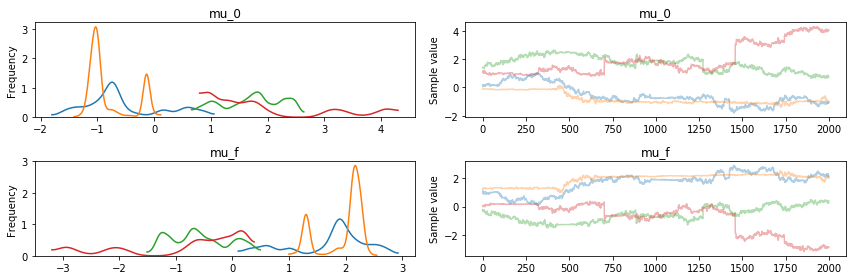

In [13]:
pm.traceplot(hreg_trace,varnames=['mu_0','mu_f'])
pass

In [15]:
pm.summary(hreg_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_0,0.580597,1.448253,0.144139,-1.588053,3.264596,2.759433,2.263582
mu_f,0.561423,1.449689,0.144284,-2.120006,2.736050,2.747784,2.274722
intercept__0,0.432543,1.466341,0.144690,-1.810864,3.227250,2.974816,2.092566
intercept__1,0.428375,1.467801,0.145394,-1.740652,3.254829,2.791965,2.208618
intercept__2,0.462326,1.494455,0.147577,-1.876136,3.210504,2.798320,2.175875
intercept__3,0.424775,1.510336,0.149287,-1.825421,3.212808,2.780614,2.205074
intercept__4,0.549934,1.452987,0.143430,-1.559664,3.373173,2.884073,2.146789
intercept__5,0.621889,1.479283,0.146043,-1.594126,3.371813,2.834011,2.161665
intercept__6,0.818833,1.466141,0.144966,-1.447403,3.510737,2.718729,2.265889
intercept__7,0.526906,1.527165,0.151025,-1.828279,3.269174,2.788338,2.187133
